# Sensor Body Frame Registration 3 (cont'd)

Confirming the quaternion registration method to re-orient the rotation signals.

## Showing the Boot Orientation Results

For the Dec 30th session, plotting the sensor and boot frame orientations against eachother.

In [1]:
from sessions import Session_2023_12_30

In [2]:
session_2023_12_30 = Session_2023_12_30()

Showing the static registrations as "tared" orientations:

In [3]:
from quat import quatToEuler

euler1 = quatToEuler(session_2023_12_30.tile.static_registration.registrations[0].avg_quat)
euler2 = quatToEuler(session_2023_12_30.tile.static_registration.registrations[1].avg_quat)

print(euler1)
print(euler2)

[-97.73361335 -16.13335908 108.97759283]
[-92.75481387 -16.64967526  95.0133967 ]


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sig_proc_np import makeContinuousRange3dof
from tile import Tile

def plotTileBootOrientationWithStillZones(tile: Tile, r=[0, -1]):
    def addStillZones(ax, t, ranges, r, _color='green'):
        for range in ranges:
            if tile.time[range[0]] < tile.time[r[0]] or tile.time[range[1]] > tile.time[r[1]]: 
                continue
            ax.axvspan(t[range[0]], t[range[1]], color=_color, alpha=0.25)

    fine_rs = [r for r in tile.static_registration.ranges if r is not None]
    coarse_rs = tile.static_registration.coarse_ranges
    t = tile.time[r[0]:r[1]]
    boot_quat = tile.boot_quat[r[0]:r[1], :]
    boot_euler = np.apply_along_axis(quatToEuler, 1, boot_quat)
    # boot_euler = makeContinuousRange3dof(
    #     boot_euler,
    #     fix_0=True,
    #     fix_1=True,
    #     fix_2=True,
    # )

    sensor_quat = tile.imu.quat[r[0]:r[1], :]
    sensor_euler = np.apply_along_axis(quatToEuler, 1, sensor_quat)
    # sensor_euler = makeContinuousRange3dof(
    #     sensor_euler,
    #     fix_0=True,
    #     fix_1=True,
    #     fix_2=True,
    # )


    plt.rc('lines', linewidth=1)
    fig, ax = plt.subplots(4, figsize=(15, 10))

    ax[0].plot(t, tile.alt_lpf[r[0]:r[1]])
    addStillZones(ax[0], tile.time, fine_rs, r)
    addStillZones(ax[0], tile.time, coarse_rs, r, 'red')
    ax[0].set_title('All Tile Altitude with Still Zones', wrap=True)

    ax[1].plot(t, sensor_euler[:, 0], label='sensor')
    ax[1].plot(t, boot_euler[:, 0], label='boot')
    addStillZones(ax[1], tile.time, fine_rs, r)
    addStillZones(ax[1], tile.time, coarse_rs, r, 'red')
    ax[1].set_title('All Tile Roll with Still Zones', wrap=True)
    ax[1].legend()

    ax[2].plot(t, sensor_euler[:, 1], label='sensor')
    ax[2].plot(t, boot_euler[:, 1], label='boot')
    addStillZones(ax[2], tile.time, fine_rs, r)
    addStillZones(ax[2], tile.time, coarse_rs, r, 'red')
    ax[2].set_title('All Tile Pitch with Still Zones', wrap=True)
    ax[2].legend()

    ax[3].plot(t, sensor_euler[:, 2], label='sensor')
    ax[3].plot(t, boot_euler[:, 2], label='boot')
    addStillZones(ax[3], tile.time, fine_rs, r)
    addStillZones(ax[3], tile.time, coarse_rs, r, 'red')
    ax[3].set_title('All Tile Yaw with Still Zones', wrap=True)
    ax[3].legend()

    plt.tight_layout()
    plt.show()
    return fig

def plotAllTileBootOrientationsForRegistationZones(tile: Tile, r=[0, -1]):
    coarse_rs = tile.static_registration.coarse_ranges

    _ = plotTileBootOrientationWithStillZones(tile, r=r)
    brackets = [[r[0]+1000, r[1]+8000] for r in coarse_rs]
    _ = [plotTileBootOrientationWithStillZones(tile, r=bracket) for bracket in brackets]

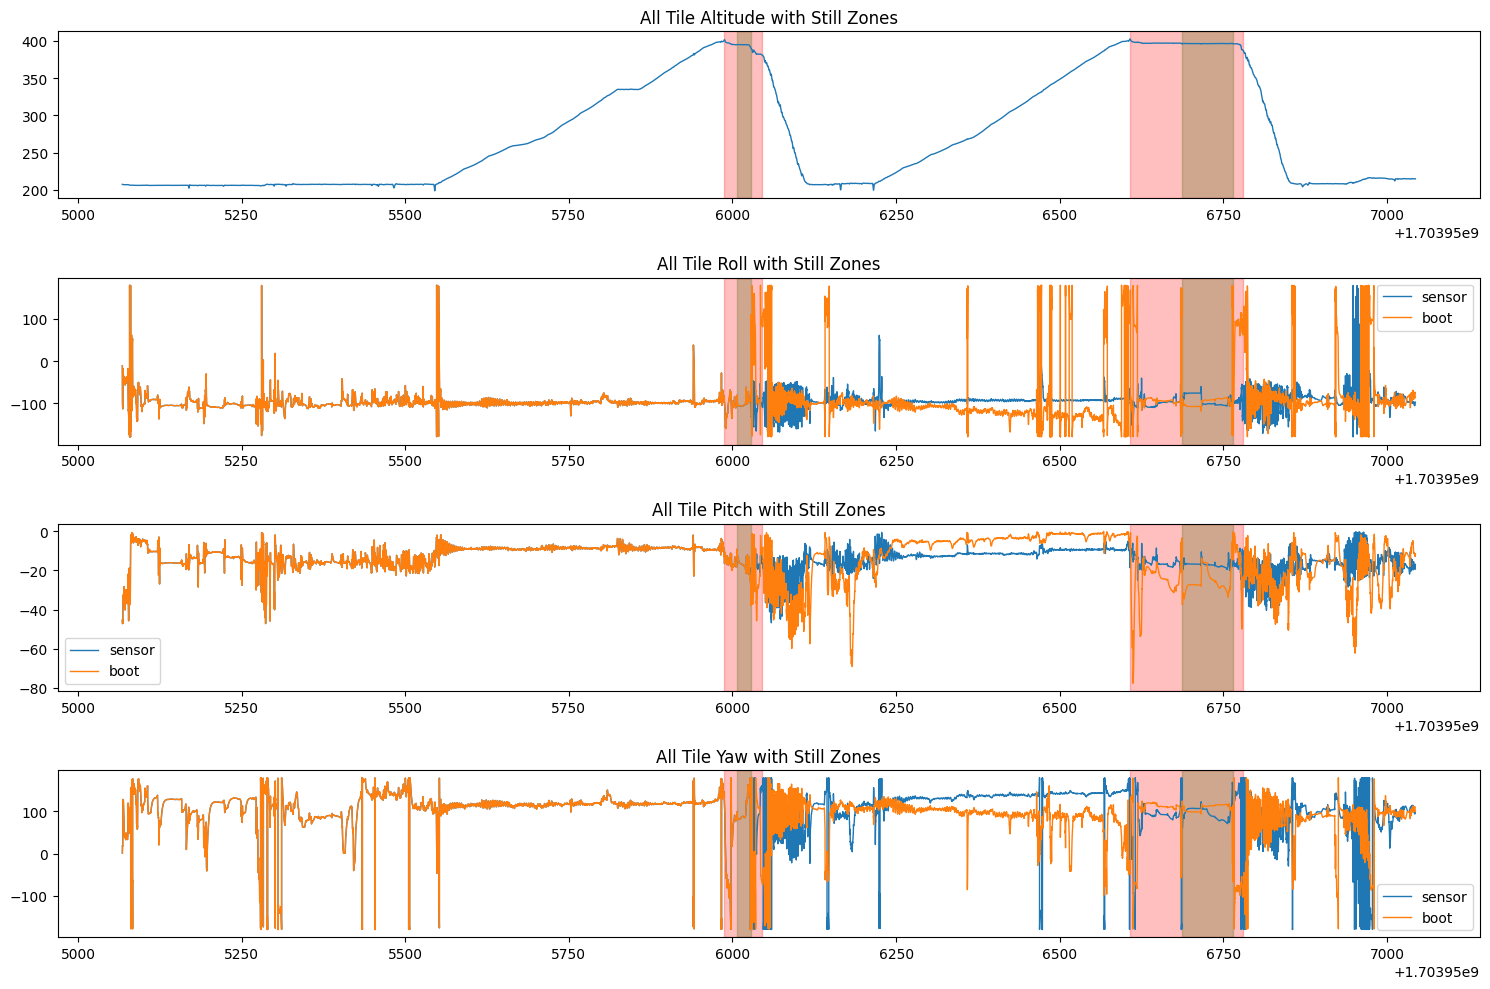

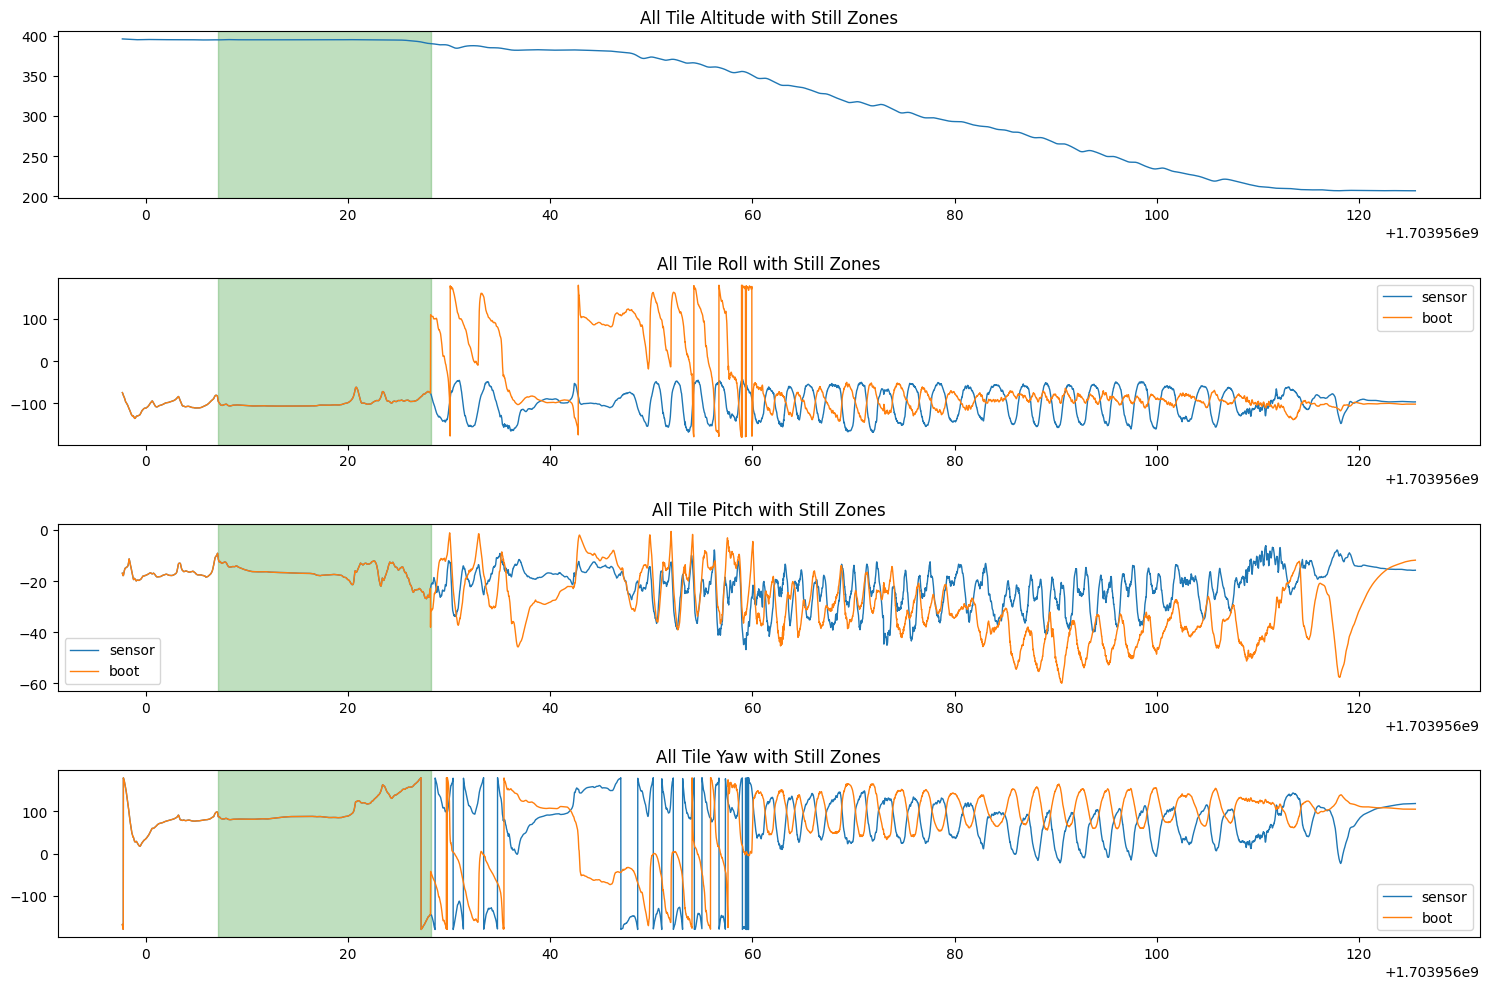

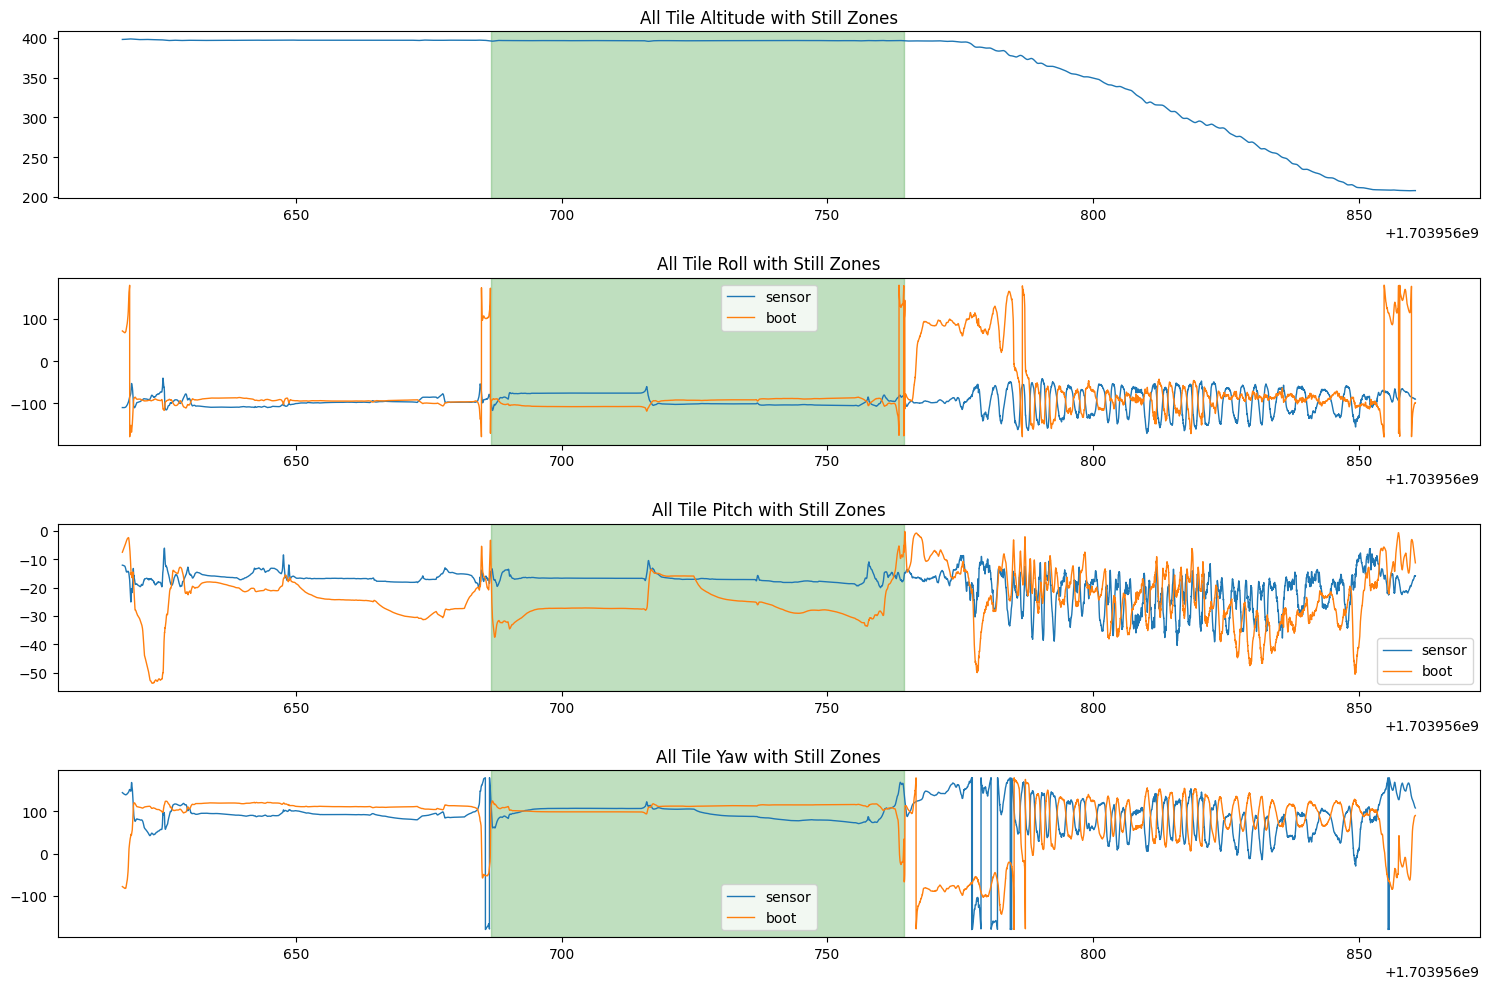

In [9]:
plotAllTileBootOrientationsForRegistationZones(session_2023_12_30.tile)